# **Использование глубоких сверточных генеративных состязательных сетей (DCGANs) для создания реалистичных изображений одежды с использованием набора данных FashionMNIST**

## **0. Импорт пакетов**

In [1]:
import tensorflow        as     tf
from   tensorflow.keras  import layers
from   keras             import preprocessing
from   keras.models      import Sequential
from   keras.layers      import Conv2D, Dropout, Dense, Flatten, Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape
import pandas            as     pd
import numpy             as     np
import matplotlib.pyplot as     plt
from   IPython           import display
import os
import glob
import imageio
import PIL
import time
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
tf.config.run_functions_eagerly(True)

2024-12-07 04:50:35.078128: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 04:50:35.078168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 04:50:35.078843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 04:50:35.083974: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **1. Загрузка и подготовка датасета Fashion MNIST**

Набор данных Fashion MNIST используется для обучения нашего DCGAN. Изображения были получены с помощью TensorFlow в оттенках серого и имеют размер $(28\times28)$.

In [2]:
# Параметры
BUFFER_SIZE = 60000
BATCH_SIZE = 128
EPOCHS = 100
noise_dim = 100
num_classes = 10
image_size = 64  # Увеличенное разрешение

# Загрузка и подготовка данных
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = (train_images / 127.5) - 1.0  # Нормализация в диапазон [-1, 1]
train_images = tf.image.resize(train_images[..., tf.newaxis], (image_size, image_size))
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2024-12-07 04:50:37.722987: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-07 04:50:37.735591: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-07 04:50:37.735624: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-07 04:50:37.737227: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-07 04:50:37.737254: I external/local_xla/xla/stream_executor

## **2. Определение архитектуры DCGANs**

### **2.1. Модель генератора**

Архитектура генератора принимает на вход вектор случайного шума длиной 100 и создает изображения размером **64×64**, используя глубокую сверточную сеть.

В данной модели:
1. **Полносвязный слой**:
   - Преобразует вектор гауссовского шума длиной 100 в вектор размером **8×8×512**.

2. **Сверточные транспонированные слои** (4 слоя):
   - **Слой 1**:
     - Размер выходного тензора: **8×8×512**.
     - Batch Normalization (BN).
     - Leaky ReLU с параметром наклона 0.3.
   - **Слой 2**:
     - Увеличивает разрешение до **16×16×256**.
     - Batch Normalization (BN).
     - Leaky ReLU с параметром наклона 0.3.
   - **Слой 3**:
     - Увеличивает разрешение до **32×32×128**.
     - Batch Normalization (BN).
     - Leaky ReLU с параметром наклона 0.3.
   - **Слой 4**:
     - Увеличивает разрешение до **64×64×64**.
     - Batch Normalization (BN).
     - Leaky ReLU с параметром наклона 0.3.

3. **Выходной слой**:
   - Преобразует тензор до **64×64×1** (одноцветные изображения).
   - Функция активации: `tanh` для нормализации значений в диапазоне [-1, 1].

**Почему такая структура?**
- **Разрешение**: Модель создает изображения размером 64×64, что делает результат генерации более реалистичным.
- **Batch Normalization**: Ускоряет обучение и стабилизирует сеть.
- **Leaky ReLU**: Помогает избежать проблемы "затухающих градиентов" и улучшает обучение.

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 512)))

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3276800   
                                                                 
 batch_normalization (Batch  (None, 32768)             131072    
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       3276800   
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 256)       1

2024-12-07 04:51:03.740805: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


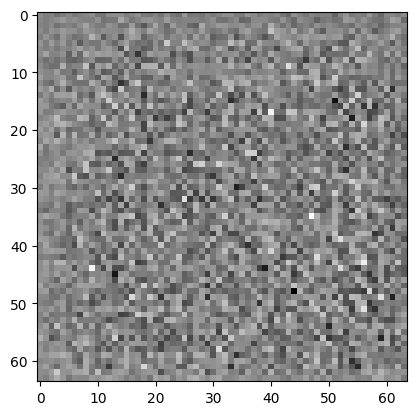

In [4]:
generator = make_generator_model()
generator.summary()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### **2.2. Дискриминаторная модель**

Архитектура дискриминатора обрабратывает изображеня с разрешением **64×64**. Модель имеет более глубокую структуру, что позволяет эффективно различать реальные и сгенерированные изображения.

В данной модели:
1. **Входной слой**:
   - Принимает изображения размером **64×64×1** (одноцветные изображения).

2. **Сверточные слои** (3 слоя):
   - **Слой 1**:
     - Размер выходного тензора: **32×32×64**.
     - Функция активации: Leaky ReLU с параметром наклона 0.3.
     - Dropout 0.3 для регуляризации.
   - **Слой 2**:
     - Размер выходного тензора: **16×16×128**.
     - Функция активации: Leaky ReLU с параметром наклона 0.3.
     - Dropout 0.3 для регуляризации.
   - **Слой 3**:
     - Размер выходного тензора: **8×8×256**.
     - Функция активации: Leaky ReLU с параметром наклона 0.3.
     - Dropout 0.3 для регуляризации.

3. **Выходной слой**:
   - После третьего сверточного слоя выходной тензор преобразуется в одномерный массив (Flatten).
   - Полносвязный слой преобразует этот массив в скаляр, представляющий вероятность того, что изображение является реальным.

**Почему такая структура?**
- **Углубление архитектуры**: Увеличенное количество сверточных слоев помогает дискриминатору лучше различать мелкие детали на изображениях высокого разрешения.
- **Dropout**: Снижает риск переобучения и делает модель более устойчивой.
- **Leaky ReLU**: Помогает предотвратить проблему "затухающих градиентов" и улучшает сходимость модели.

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(image_size, image_size, 1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [6]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1664      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)        

## **3. Определение наших потерь и оптимизаторы**

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

### **3.1. Потери генератора**

In [8]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### **3.2. Потери дискриминатора**

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

## **4. Обучение**

### **4.1. Сохранение контрольных точек**

In [10]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### **Цикл обучения**

In [11]:
# История потерь
generator_loss_historyE = []
discriminator_loss_historyE = []

generator_loss_history = []
discriminator_loss_history = []

seed = tf.random.normal([16, noise_dim])

In [12]:
# Обучение
@tf.function
def train_step(images, count):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        generator_loss_history.append(gen_loss)
        discriminator_loss_history.append(disc_loss)

        if count == 235: # images per batch
            generator_loss_historyE.append(gen_loss)
            discriminator_loss_historyE.append(disc_loss)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [13]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        count = 0
        for image_batch in train_dataset:
            count += 1
            train_step(image_batch, count)
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f'Эпоха {epoch + 1} завершена.')
            generate_and_save_images(generator, epoch + 1, seed)
        print(f'Эпоха {epoch + 1} завершена за {time.time() - start:.2f} сек.')

### **Создание и сохранение изображени**

In [14]:
# Визуализация
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0  # Перевод в [0, 1]
    plt.figure(figsize=(8, 8))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Эпоха {epoch}')
    plt.show()

### **Обучение модели DCGAN**

Эпоха 1 завершена за 72.52 сек.
Эпоха 2 завершена за 63.45 сек.
Эпоха 3 завершена за 67.70 сек.
Эпоха 4 завершена за 62.88 сек.
Эпоха 5 завершена за 63.47 сек.
Эпоха 6 завершена за 63.20 сек.
Эпоха 7 завершена за 63.04 сек.
Эпоха 8 завершена за 62.92 сек.
Эпоха 9 завершена за 62.21 сек.
Эпоха 10 завершена.


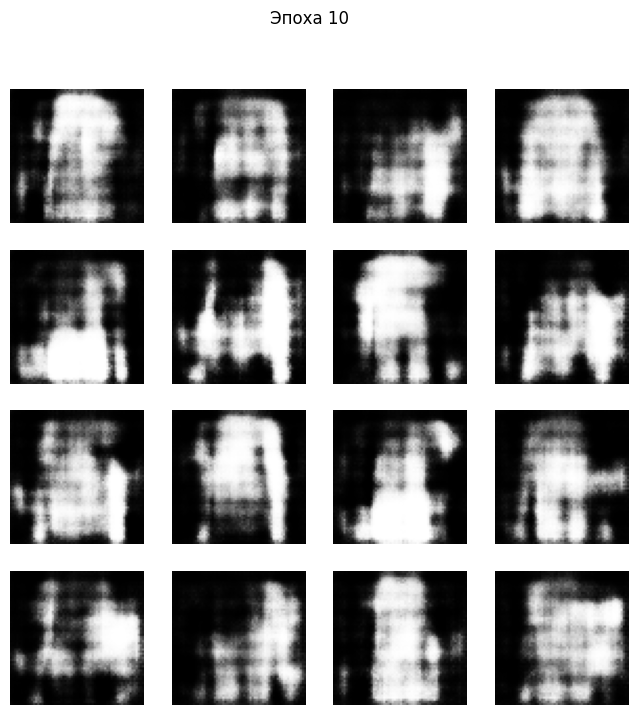

Эпоха 10 завершена за 62.71 сек.
Эпоха 11 завершена за 63.44 сек.
Эпоха 12 завершена за 63.24 сек.
Эпоха 13 завершена за 63.30 сек.
Эпоха 14 завершена за 62.35 сек.
Эпоха 15 завершена за 62.41 сек.
Эпоха 16 завершена за 63.32 сек.
Эпоха 17 завершена за 64.01 сек.
Эпоха 18 завершена за 67.07 сек.
Эпоха 19 завершена за 64.44 сек.
Эпоха 20 завершена.


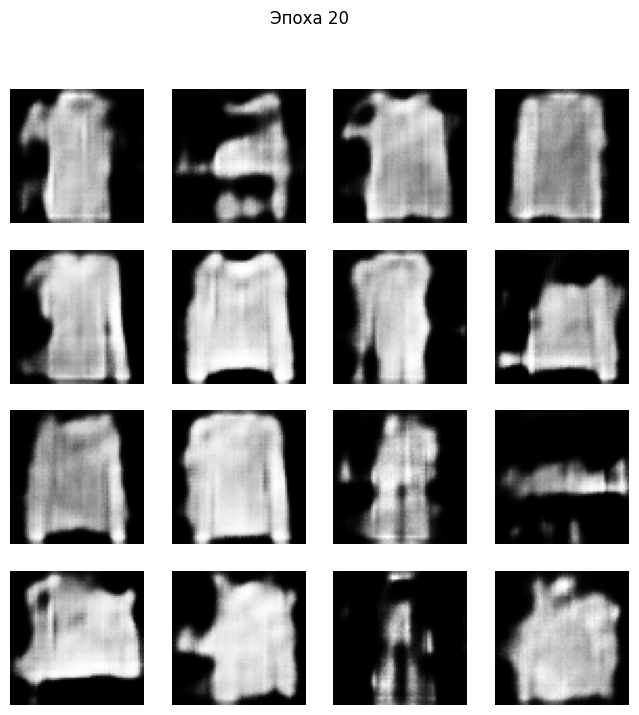

Эпоха 20 завершена за 64.05 сек.
Эпоха 21 завершена за 62.57 сек.
Эпоха 22 завершена за 63.80 сек.
Эпоха 23 завершена за 64.53 сек.
Эпоха 24 завершена за 63.70 сек.
Эпоха 25 завершена за 64.11 сек.
Эпоха 26 завершена за 62.85 сек.
Эпоха 27 завершена за 62.04 сек.
Эпоха 28 завершена за 63.47 сек.
Эпоха 29 завершена за 62.89 сек.
Эпоха 30 завершена.


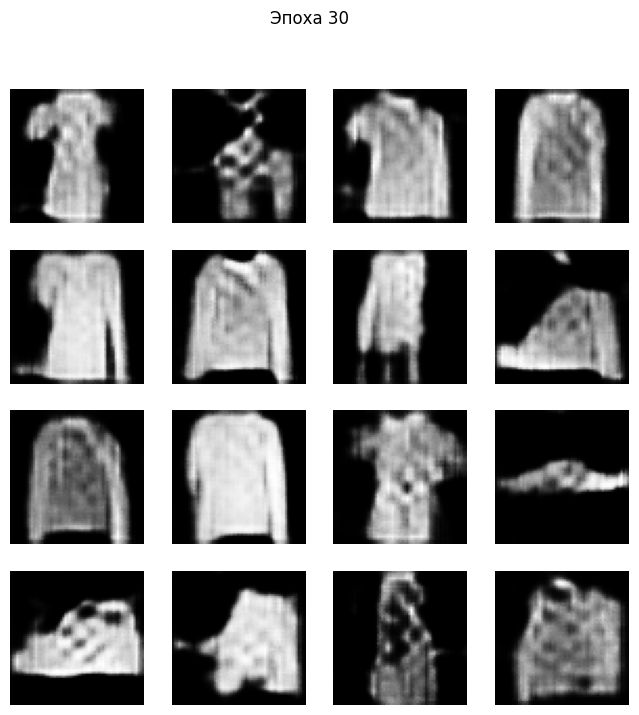

Эпоха 30 завершена за 63.31 сек.
Эпоха 31 завершена за 63.16 сек.
Эпоха 32 завершена за 62.71 сек.
Эпоха 33 завершена за 61.90 сек.
Эпоха 34 завершена за 63.15 сек.
Эпоха 35 завершена за 63.45 сек.
Эпоха 36 завершена за 62.25 сек.
Эпоха 37 завершена за 81.90 сек.
Эпоха 38 завершена за 62.93 сек.
Эпоха 39 завершена за 63.86 сек.
Эпоха 40 завершена.


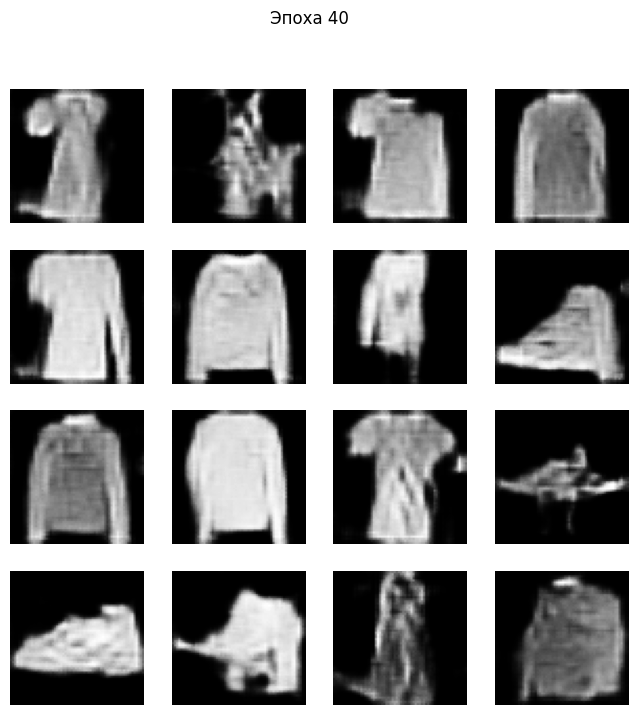

Эпоха 40 завершена за 65.10 сек.
Эпоха 41 завершена за 65.60 сек.
Эпоха 42 завершена за 64.62 сек.
Эпоха 43 завершена за 64.35 сек.
Эпоха 44 завершена за 62.74 сек.
Эпоха 45 завершена за 64.13 сек.
Эпоха 46 завершена за 63.91 сек.
Эпоха 47 завершена за 62.92 сек.
Эпоха 48 завершена за 62.35 сек.
Эпоха 49 завершена за 63.22 сек.
Эпоха 50 завершена.


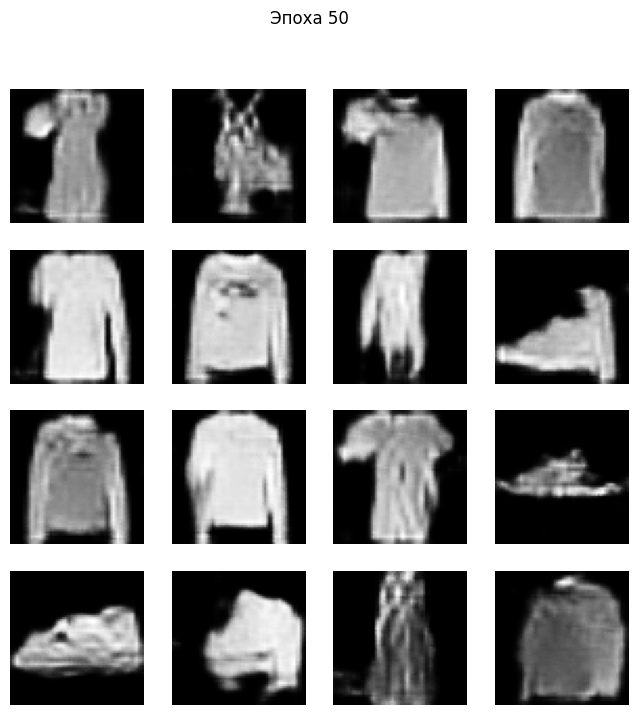

Эпоха 50 завершена за 63.33 сек.
Эпоха 51 завершена за 64.95 сек.
Эпоха 52 завершена за 63.33 сек.
Эпоха 53 завершена за 63.79 сек.
Эпоха 54 завершена за 62.61 сек.
Эпоха 55 завершена за 61.94 сек.
Эпоха 56 завершена за 63.78 сек.
Эпоха 57 завершена за 64.64 сек.
Эпоха 58 завершена за 62.64 сек.
Эпоха 59 завершена за 62.13 сек.
Эпоха 60 завершена.


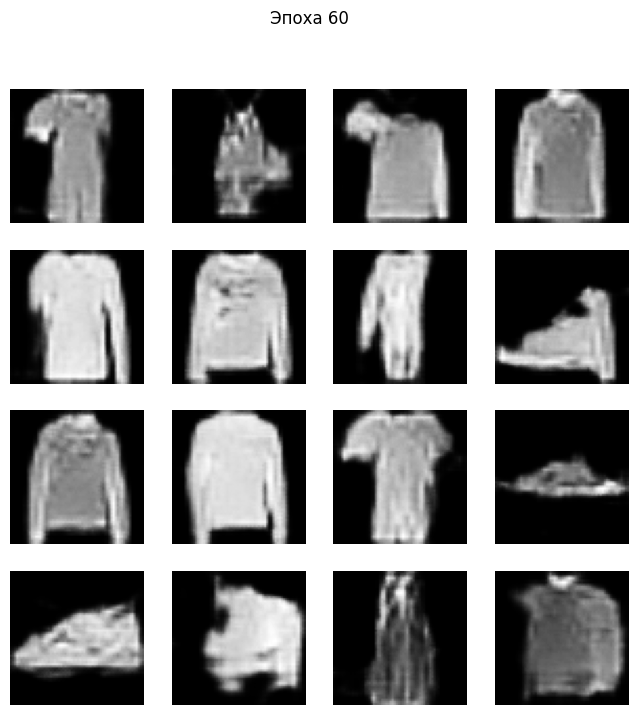

Эпоха 60 завершена за 62.77 сек.
Эпоха 61 завершена за 63.93 сек.
Эпоха 62 завершена за 63.93 сек.
Эпоха 63 завершена за 63.86 сек.
Эпоха 64 завершена за 64.43 сек.
Эпоха 65 завершена за 62.37 сек.
Эпоха 66 завершена за 62.11 сек.
Эпоха 67 завершена за 62.67 сек.
Эпоха 68 завершена за 64.31 сек.
Эпоха 69 завершена за 62.17 сек.
Эпоха 70 завершена.


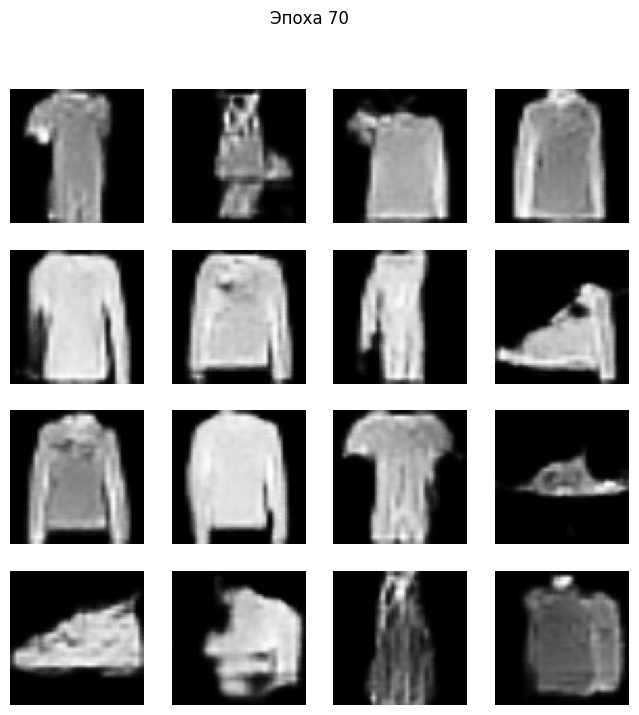

Эпоха 70 завершена за 65.49 сек.
Эпоха 71 завершена за 62.45 сек.
Эпоха 72 завершена за 60.22 сек.
Эпоха 73 завершена за 61.27 сек.
Эпоха 74 завершена за 63.25 сек.
Эпоха 75 завершена за 63.15 сек.
Эпоха 76 завершена за 63.08 сек.
Эпоха 77 завершена за 61.68 сек.
Эпоха 78 завершена за 60.95 сек.
Эпоха 79 завершена за 62.19 сек.
Эпоха 80 завершена.


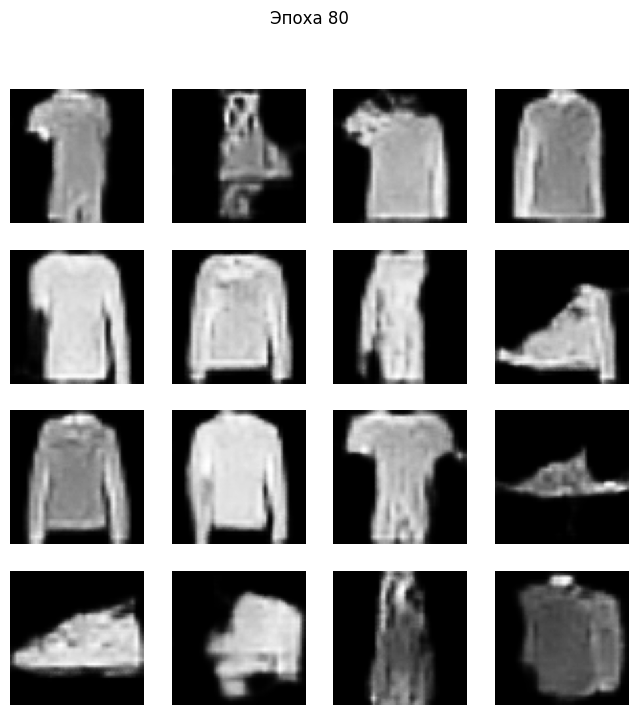

Эпоха 80 завершена за 64.07 сек.
Эпоха 81 завершена за 62.79 сек.
Эпоха 82 завершена за 62.82 сек.
Эпоха 83 завершена за 61.32 сек.
Эпоха 84 завершена за 61.02 сек.
Эпоха 85 завершена за 62.66 сек.
Эпоха 86 завершена за 63.86 сек.
Эпоха 87 завершена за 63.49 сек.
Эпоха 88 завершена за 63.16 сек.
Эпоха 89 завершена за 61.62 сек.
Эпоха 90 завершена.


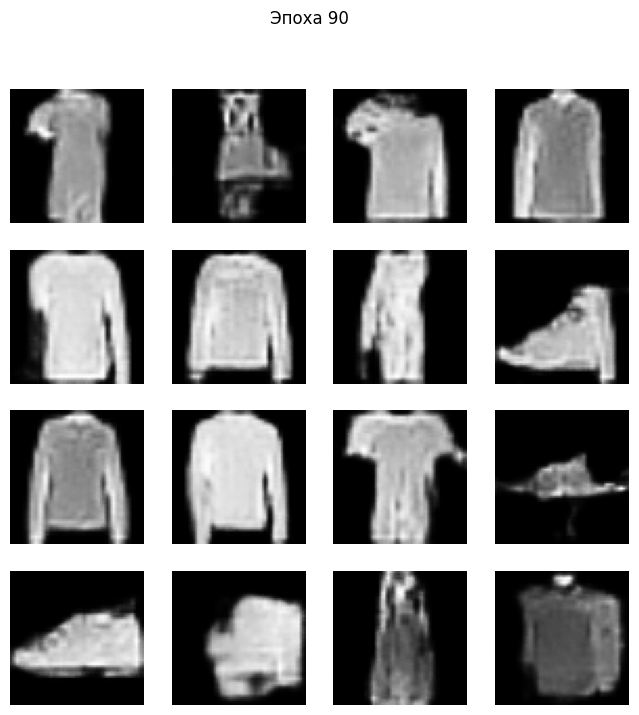

Эпоха 90 завершена за 62.53 сек.
Эпоха 91 завершена за 63.72 сек.
Эпоха 92 завершена за 63.92 сек.
Эпоха 93 завершена за 63.27 сек.
Эпоха 94 завершена за 62.19 сек.
Эпоха 95 завершена за 61.05 сек.
Эпоха 96 завершена за 60.59 сек.
Эпоха 97 завершена за 65.89 сек.
Эпоха 98 завершена за 63.29 сек.
Эпоха 99 завершена за 63.68 сек.
Эпоха 100 завершена.


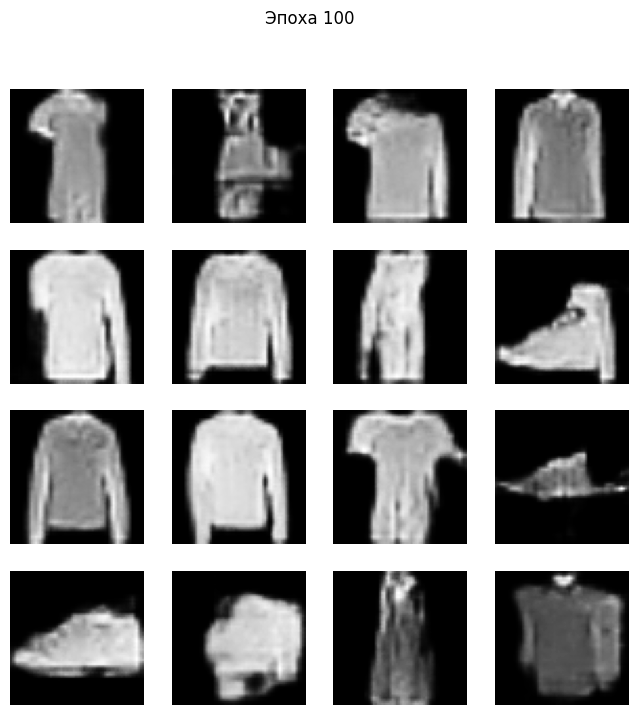

Эпоха 100 завершена за 60.52 сек.


In [15]:
train(train_dataset, EPOCHS)

In [16]:
# Restore Latest Checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## **5. Графики потерь**

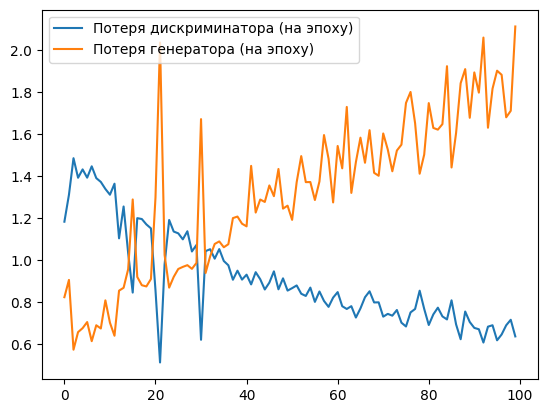

In [17]:
plt.plot(discriminator_loss_historyE, label='Потеря дискриминатора (на эпоху)')
plt.plot(generator_loss_historyE, label='Потеря генератора (на эпоху)')
plt.legend()
plt.show()

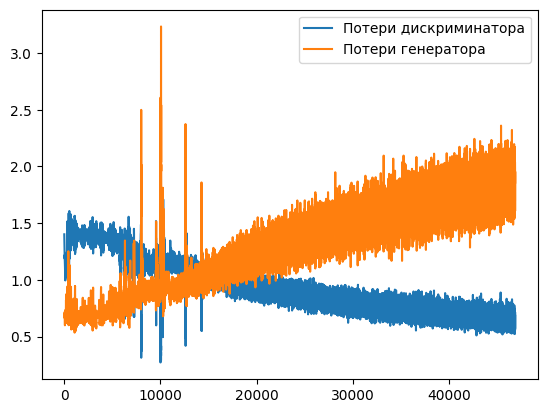

In [18]:
plt.plot(discriminator_loss_history, label='Потери дискриминатора')
plt.plot(generator_loss_history, label='Потери генератора')
plt.legend()
plt.show()

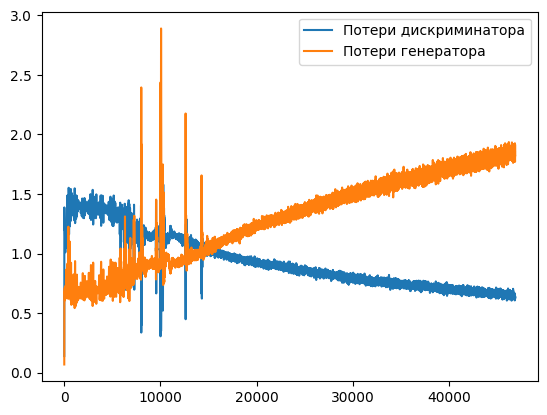

In [19]:
from scipy.signal import lfilter

n = 10
b = [1.0 / n] * n
a = 1
disc_y = lfilter(b,a,discriminator_loss_history)
gen_y = lfilter(b,a,generator_loss_history)
plt.plot(disc_y, label='Потери дискриминатора')
plt.plot(gen_y, label='Потери генератора')
plt.legend()
plt.show()


**Динамика потерь:** 

Потери генератора начинают расти с увеличением эпох. Это свидетельствует о том, что дискриминатор становится всё более сильным и генератору сложнее "обманывать" его. 

Потери дискриминатора уменьшаются, что подтверждает улучшение его способности классифицировать реальные и сгенерированные изображения.

Дискриминатор значительно сильнее генератора. Он быстро обучается различать реальные и сгенерированные изображения, что приводит к увеличению потерь генератора.